<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Otimização do Modelo SARIMA</font></b></strong>

No modelo 18 criamos um Modelo SARIMA aplicando Grid Search Stepwise para buscar os melhores valores dos hiperparâmetros.

Agora, vamos tentar melhorar a performance do modelo criado mudando a estratégia do Grid Search.  

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

statsmodels     0.12.1
sklearn         0.24.0
scipy           1.5.4
statsmodels.api 0.12.1
matplotlib      3.3.3
pandas          1.1.5
numpy           1.19.5
Data Science Academy


## Definição do Problema de Negócio

Previsão do distanciamento social em Minas Gerais.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o distanciamento social em Minas Gerais. Os dados tem registros de 15/02/2020 a 29/01/2021.

Será fornecido 1 dataset com 2 colunas, data e distanciamento social.

In [3]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [4]:
# Dados
dataframe.head()

,QT_INTER
Data,
2020-02-15,31.6
2020-02-16,38.9
2020-02-17,24.0
2020-02-18,26.5
2020-02-19,27.8


In [5]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['QT_INTER']

In [6]:
# Random seed 
np.random.seed(7)

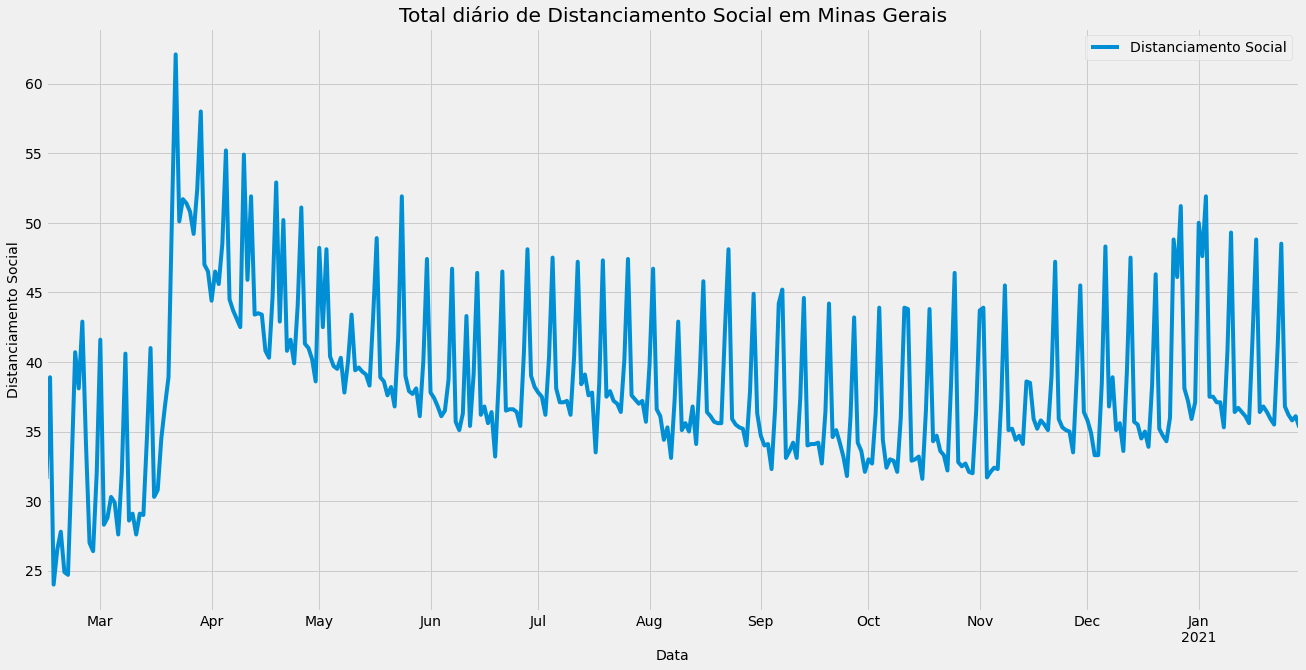

In [7]:
# Plot
target.plot(title = 'Total diário de Distanciamento Social em Minas Gerais', fontsize = 14, label = 'Distanciamento Social') 
plt.xlabel("Data") 
plt.ylabel("Distanciamento Social") 
plt.legend(loc = 'best') 
plt.show()

In [8]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

262 88


In [9]:
# Aplicando transformação de log
#treino_log = np.log(treino) 

In [10]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
#teste_log = np.log(teste)

In [11]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Otimização do Modelo SARIMA

### Grid Search Método 2 

Neste método de Grid Search, nós testamos diversas combinações dos hiperparâmetros do modelo SARIMA. Tome cuidado para não exagerar nas combinações. Valores de 0 e 1 resolvem a grande maioria dos problemas.

In [12]:
# Vamos definir p, d e q para que tenham valores entre 0 e 2 e testaremos as combinações.
p = d = q = range(0, 2)

Agora geramos diferentes combinações de p, d e q.

In [13]:
# Lista de combinações de p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [24]:
# Lista de combinações dos hiperparâmetros sazonais P, D e Q
# Estamos usando List Comprehension
seasonal_pdq = [(x[0], x[1], x[2], 10) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 10),
 (0, 0, 1, 10),
 (0, 1, 0, 10),
 (0, 1, 1, 10),
 (1, 0, 0, 10),
 (1, 0, 1, 10),
 (1, 1, 0, 10),
 (1, 1, 1, 10)]

In [25]:
print('\nExemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Exemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:

SARIMAX: (0, 0, 1) x (0, 0, 1, 10)
SARIMAX: (0, 0, 1) x (0, 1, 0, 10)
SARIMAX: (0, 1, 0) x (0, 1, 1, 10)
SARIMAX: (0, 1, 0) x (1, 0, 0, 10)


In [34]:
# Grid Search
#warnings.filterwarnings("ignore")

# Menor valor possível para a estatística AIC (nosso objetivo na otimização do modelo)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(treino,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{}10 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}10 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anacon

SARIMA(0, 0, 0)x(0, 0, 0, 10)10 - AIC:2655.5015266760583
SARIMA(0, 0, 0)x(0, 0, 1, 10)10 - AIC:2284.925869014372
SARIMA(0, 0, 0)x(0, 1, 0, 10)10 - AIC:1733.900226029389


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 0)x(0, 1, 1, 10)10 - AIC:1593.578803554528
SARIMA(0, 0, 0)x(1, 0, 0, 10)10 - AIC:1742.738876924866


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 0)x(1, 0, 1, 10)10 - AIC:1663.636198858273
SARIMA(0, 0, 0)x(1, 1, 0, 10)10 - AIC:1609.357531594632


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 0)x(1, 1, 1, 10)10 - AIC:1576.2690384527327
SARIMA(0, 0, 1)x(0, 0, 0, 10)10 - AIC:2320.2068185140843


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 1)x(0, 0, 1, 10)10 - AIC:2006.1774007953857
SARIMA(0, 0, 1)x(0, 1, 0, 10)10 - AIC:1669.9263674882206


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 1)x(0, 1, 1, 10)10 - AIC:1510.138869683057
SARIMA(0, 0, 1)x(1, 0, 0, 10)10 - AIC:1684.9231224234613


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Guto\Anaconda3\lib\sit

SARIMA(0, 0, 1)x(1, 0, 1, 10)10 - AIC:1684.1394354501508
SARIMA(0, 0, 1)x(1, 1, 0, 10)10 - AIC:1572.4107467589179
SARIMA(0, 0, 1)x(1, 1, 1, 10)10 - AIC:1502.2747174210267
SARIMA(0, 1, 0)x(0, 0, 0, 10)10 - AIC:1622.8493955866206
SARIMA(0, 1, 0)x(0, 0, 1, 10)10 - AIC:1556.608674012982
SARIMA(0, 1, 0)x(0, 1, 0, 10)10 - AIC:1728.1344868687445


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anacon

SARIMA(0, 1, 0)x(0, 1, 1, 10)10 - AIC:1529.79214104157
SARIMA(0, 1, 0)x(1, 0, 0, 10)10 - AIC:1564.4258716290835


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 10)10 - AIC:1548.8143830593112
SARIMA(0, 1, 0)x(1, 1, 0, 10)10 - AIC:1626.8587118800258


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 1, 1, 10)10 - AIC:1530.3763680538743
SARIMA(0, 1, 1)x(0, 0, 0, 10)10 - AIC:1562.6635017620274
SARIMA(0, 1, 1)x(0, 0, 1, 10)10 - AIC:1483.4007172060888


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anacon

SARIMA(0, 1, 1)x(0, 1, 0, 10)10 - AIC:1716.613405338036


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(0, 1, 1, 10)10 - AIC:1464.7305059525897
SARIMA(0, 1, 1)x(1, 0, 0, 10)10 - AIC:1502.5161223320588


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 0, 1, 10)10 - AIC:1484.356891889352


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 1, 0, 10)10 - AIC:1554.0625749967335


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 1, 1, 10)10 - AIC:1459.2408196991128
SARIMA(1, 0, 0)x(0, 0, 0, 10)10 - AIC:1630.8677502029796
SARIMA(1, 0, 0)x(0, 0, 1, 10)10 - AIC:1565.256455408437


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anacon

SARIMA(1, 0, 0)x(0, 1, 0, 10)10 - AIC:1666.7277624076282


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 0, 0)x(0, 1, 1, 10)10 - AIC:1485.9049113693618
SARIMA(1, 0, 0)x(1, 0, 0, 10)10 - AIC:1565.2553122588347


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 0, 0)x(1, 0, 1, 10)10 - AIC:1559.5879103417305
SARIMA(1, 0, 0)x(1, 1, 0, 10)10 - AIC:1551.122160548071


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 0, 0)x(1, 1, 1, 10)10 - AIC:1486.0533913071288
SARIMA(1, 0, 1)x(0, 0, 0, 10)10 - AIC:1576.0105523006205


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 0, 1)x(0, 0, 1, 10)10 - AIC:1492.232909104634
SARIMA(1, 0, 1)x(0, 1, 0, 10)10 - AIC:1658.599310617681


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 0, 1)x(0, 1, 1, 10)10 - AIC:1475.9856176507258


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 0, 1)x(1, 0, 0, 10)10 - AIC:1504.5178248179584


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 0, 1)x(1, 0, 1, 10)10 - AIC:1489.998090554161


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 0, 1)x(1, 1, 0, 10)10 - AIC:1547.056007088612


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 0, 1)x(1, 1, 1, 10)10 - AIC:1476.8577369849795
SARIMA(1, 1, 0)x(0, 0, 0, 10)10 - AIC:1607.485086399495
SARIMA(1, 1, 0)x(0, 0, 1, 10)10 - AIC:1541.3213019786597
SARIMA(1, 1, 0)x(0, 1, 0, 10)10 - AIC:1724.24331086656


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anacon

SARIMA(1, 1, 0)x(0, 1, 1, 10)10 - AIC:1516.091532196998
SARIMA(1, 1, 0)x(1, 0, 0, 10)10 - AIC:1542.1027354143448


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 0, 1, 10)10 - AIC:1532.103929308817
SARIMA(1, 1, 0)x(1, 1, 0, 10)10 - AIC:1590.5782002708324


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 1, 1, 10)10 - AIC:1517.0571333151006
SARIMA(1, 1, 1)x(0, 0, 0, 10)10 - AIC:1544.1272216787822


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(0, 0, 1, 10)10 - AIC:1479.3728719423234
SARIMA(1, 1, 1)x(0, 1, 0, 10)10 - AIC:1658.8163522795512


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(0, 1, 1, 10)10 - AIC:1451.114261107131
SARIMA(1, 1, 1)x(1, 0, 0, 10)10 - AIC:1486.279913502328


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 0, 1, 10)10 - AIC:1481.120493499268


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 0, 10)10 - AIC:1547.2468675946834


C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 1, 10)10 - AIC:1452.7250951365804

Modelo com Menor Valor de AIC: SARIMA(1, 1, 1)x(0, 1, 1, 10)10 - AIC:1451.114261107131


In [35]:
# Treina o modelo com a melhor combinação de hiperparâmetros
modelo_sarima_v2 = sm.tsa.statespace.SARIMAX(treino,
                                             order = (1, 1, 1),
                                             seasonal_order = (0, 1, 1, 10),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [36]:
# Treinamento (Fit) do modelo
modelo_sarima_v2_fit = modelo_sarima_v2.fit()

In [37]:
# Sumário do modelo
print(modelo_sarima_v2_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           QT_INTER   No. Observations:                  262
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 10)   Log Likelihood                -721.557
Date:                            Sun, 07 Feb 2021   AIC                           1451.114
Time:                                    12:16:33   BIC                           1465.020
Sample:                                02-15-2020   HQIC                          1456.718
                                     - 11-02-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3006      0.079      3.816      0.000       0.146       0.455
ma.L1         -0.8477      0.051   

Nas próximas aulas vamos interpretar o sumário do modelo e comparar as versões dos modelos SARIMA que iremos criar.

Mas perceba o valor de AIC. Conseguimos reduzí-lo de forma considerável e a única mudança foi a otimizaçã dos hiperparâmetros.

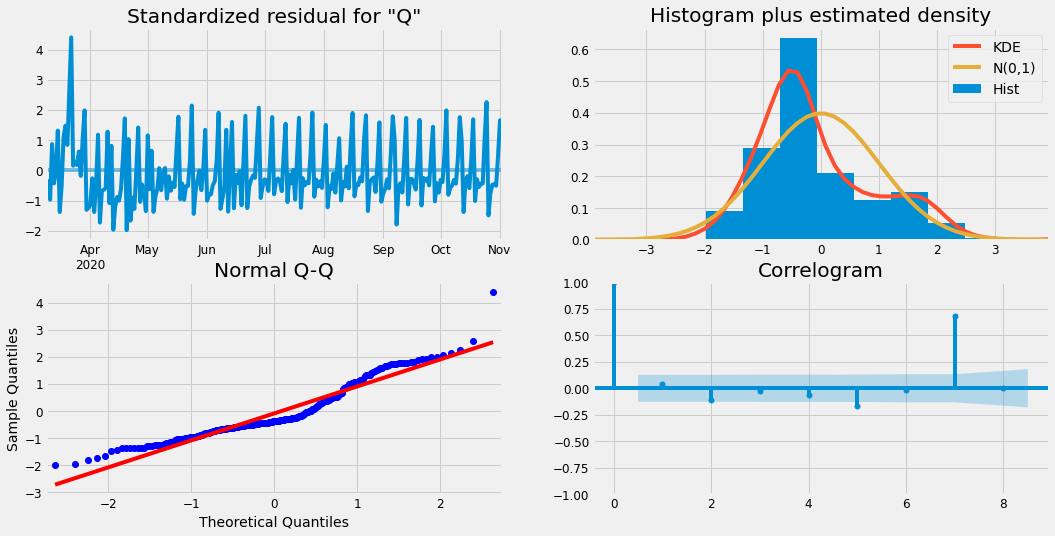

In [38]:
# Diagnóstico do modelo
modelo_sarima_v2_fit.plot_diagnostics(lags = 8, figsize = (16,8))
plt.show()

**Diagnóstico do Modelo:**

- Nossa principal preocupação é garantir que os resíduos do nosso modelo não sejam correlacionados e sejam normalmente distribuídos com média zero.

- Se o modelo SARIMA não atender a essas propriedades, é uma boa indicação de que pode ser melhorado ainda mais.

O diagnóstico do modelo sugere que o resíduo do modelo é normalmente distribuído com base no seguinte:

- No gráfico superior direito, a linha azul do KDE segue de perto a linha N (0,1). Onde N (0,1) é a notação padrão para uma distribuição normal com média 0 e desvio padrão de 1. Essa é uma boa indicação de que os resíduos são normalmente distribuídos.

- O gráfico qq no canto inferior esquerdo mostra que a distribuição ordenada de resíduos (pontos azuis) segue a tendência linear das amostras coletadas de uma distribuição normal padrão. Novamente, essa é uma forte indicação de que os resíduos são normalmente distribuídos.

- Os resíduos ao longo do tempo (gráfico superior esquerdo) não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco.

- Isso é confirmado pelo gráfico de autocorrelação (isto é, correlograma) no canto inferior direito, que mostra que os resíduos da série temporal têm baixa correlação com versões atrasadas de si.

In [39]:
# Vamos fazer previsões um passo a frente
sarima_predict_2 = modelo_sarima_v2_fit.get_prediction(start = pd.to_datetime('2020-11-02'), 
                                                       end = pd.to_datetime('2021-01-29'),
                                                       dynamic = False)

In [40]:
# Intervalo de confiança
sarima_predict_conf_2 = sarima_predict_2.conf_int()
#sarima_predict_conf_2

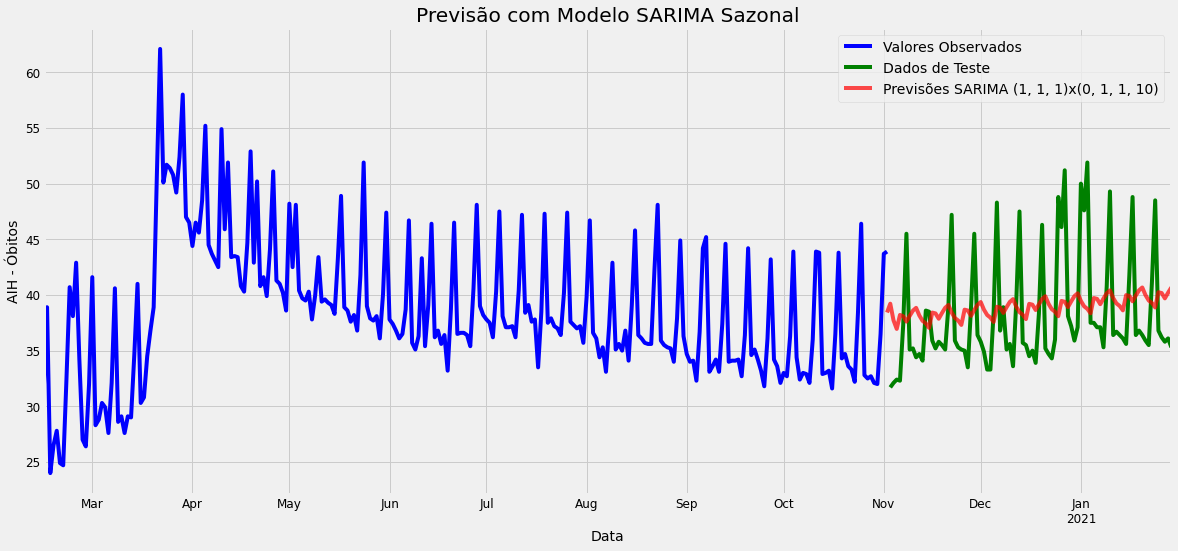

In [41]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 8

ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
sarima_predict_2.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (1, 1, 1)x(0, 1, 1, 10)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
#ax.fill_between(sarima_predict_conf_2.index,
#                # lower sales
#                sarima_predict_conf_2.iloc[:, 0],
#                # upper sales
#                sarima_predict_conf_2.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão com Modelo SARIMA Sazonal')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend()
plt.show()

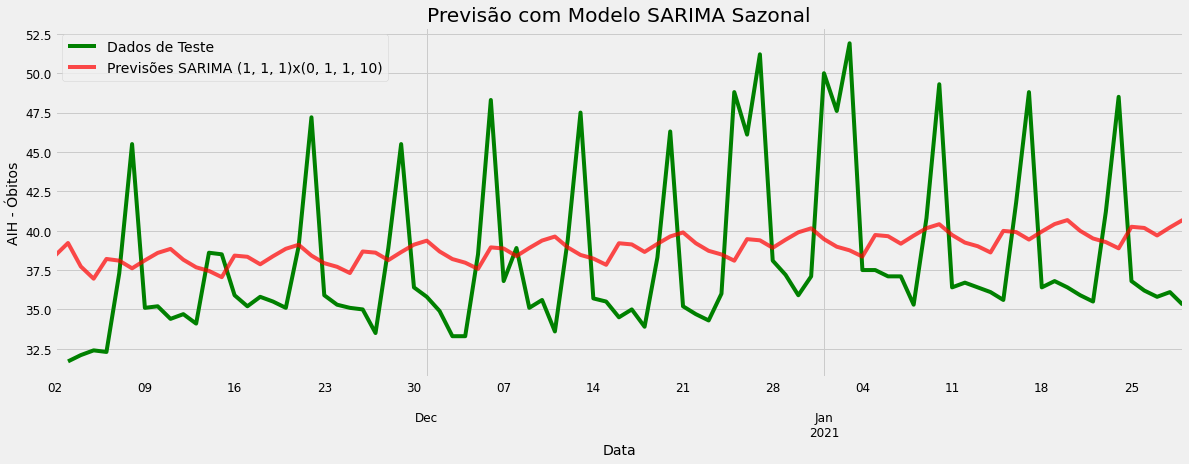

In [42]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 6

#ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
sarima_predict_2.predicted_mean.plot(ax = t, 
                                     label = 'Previsões SARIMA (1, 1, 1)x(0, 1, 1, 10)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Títulos e Legendas
plt.title('Previsão com Modelo SARIMA Sazonal')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend(loc = 'upper left')
plt.show()

Embora ainda não esteja ideal, o modelo fez um bom trabalho nas previsões.

In [44]:
# Calculando a performance
sarima_results = performance(treino, sarima_predict_2.predicted_mean)
#sarima_results

MSE das previsões é 29.9656
RMSE das previsões é 5.4741
MAPE das previsões é 12.4694


In [46]:
# Calculando a performance
sarima_results = performance(teste, sarima_predict_2.predicted_mean)
#sarima_results

MSE das previsões é 25.1044
RMSE das previsões é 5.0104
MAPE das previsões é 10.6838


O erro do modelo aumentou um pouco, mas não podemos usar apenas uma medida para avaliar o modelo. Falaremos mais sobre isso nas aulas seguintes. Vejamos como o modelo se sai em um horizonte de previsão maior.

In [53]:
# Forecast (previsão) de 60 passos no tempo
horizonte_60_predict_2 = modelo_sarima_v2_fit.get_forecast(steps = 88)

In [54]:
# Intervalo de confiança
horizonte_60_predict_2_conf_2 = horizonte_60_predict_2.conf_int()
#horizonte_60_predict_2_conf_2

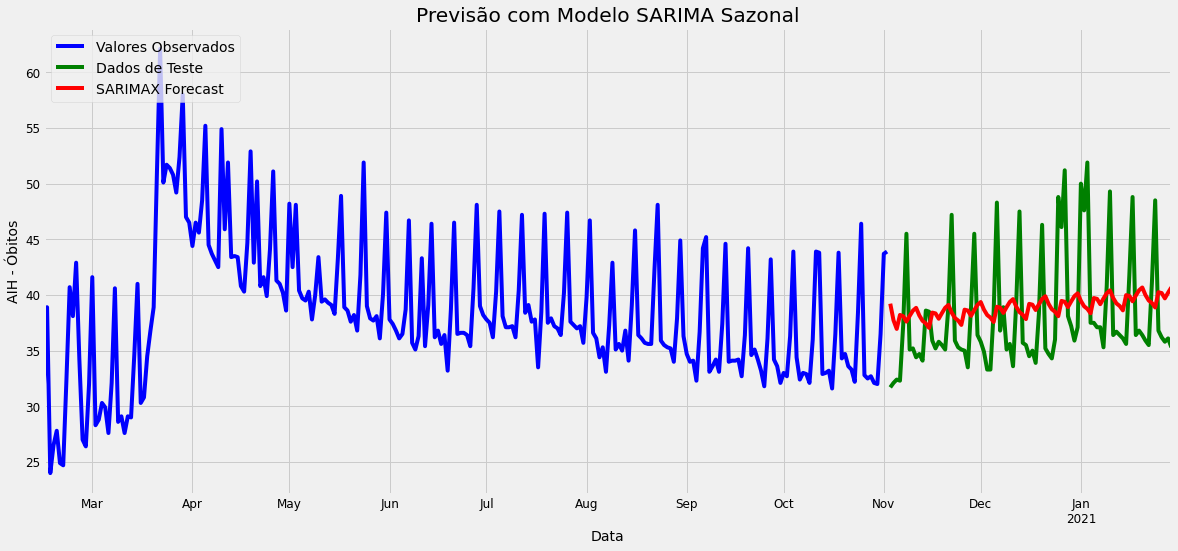

In [55]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 8

ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
horizonte_60_predict_2.predicted_mean.plot(ax = ax, label = 'SARIMAX Forecast', color = 'red')

# Plot do intervalo de confiança
#ax.fill_between(horizonte_60_predict_2_conf_2.index,
#                horizonte_60_predict_2_conf_2.iloc[:, 0],
#                horizonte_60_predict_2_conf_2.iloc[:, 1], color = 'k', alpha = .25)

# Plot
plt.title('Previsão com Modelo SARIMA Sazonal')
ax.set_xlabel('Data')
ax.set_ylabel('AIH - Óbitos')
plt.legend(loc = 'upper left')
plt.show()

Por que a área cinza aumenta? Porque quanto maior o horizonte de previsão, maior a incerteza das previsões. Veja que estamos fazendo previsões de vendas para 5 anos (60 passos no tempo em nossa série), o que aumenta a incerteza a cada novo passo de tempo previsto.

In [56]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v2_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [2.30771043e-64]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95%. 

O modelo SARIMA (0, 1, 1)x(0, 1, 1, 12) fornece um bom ajuste e boa capacidade de previsão.

Como estamos até agora:

- Modelo 15 --> Modelo ARMA (9, 6) - AIC = 1295.100 e RMSE = 3.5966
- Modelo 16 --> Modelo ARIMA Forcast (4, 1, 5) Forecast - AIC = 1385.134 e RMSE = 3.7513
- Modelo 17 --> Modelo SARIMA (2, 1, 1)x(2, 1, 0, 10) - AIC = 1449.398 e RMSE = 6.5842
- Modelo 18 --> Modelo SARIMA (1, 1, 1)x(0, 1, 1, 10) - AIC = 1451.114 e RMSE = 5.0104

Que diferença faz uma otimização de hiperparâmetros, não é verdade? Incrível como conseguimos melhorar a performance do nosso modelo aplicando técnicas de otimização.

Embora não seja o caso aqui, se tivermos discrepâncias entre o AIC e o RMSE, nossa escolha deve ser pelo AIC.

O RMSE é o erro do modelo com os dados atuais, de teste.

O AIC avalia a performance global do modelo e a sua capacidade de prever em um horizonte de previsão além das amostra de teste (ou seja, com novos dados). E isso é o que queremos! Logo, havendo discrepância das métricas, devemos escolher o modelo com menor AIC.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim